# **<center> `Note`: Move Notebook to `scripts` folder**

## **DineMate Foodbot**

DineMate is an AI-powered restaurant assistant that handles food orders efficiently. It uses LangGraph
for state management, LangChain for LLM integration, and SQLite for storing orders. This script provides
a CLI interface for users to interact with the bot, view the menu, place orders, and track orders.

## **Features**
- Fetches and displays the restaurant menu.
- Processes user orders, calculates totals, and saves them to a database.
- Supports order modification/cancellation within 10 minutes.
- Provides polite and emoji-enhanced responses for a user-friendly experience.

## **Dependencies**
- `langchain_groq`: For LLM integration with Grok.
- `langgraph`: For state management and workflow orchestration.
- `sqlite3`: For database operations.
- `python-dotenv`: For environment variable management.
- `utils`: Custom module for LLM configuration (assumed to exist).
- `SQLLITE_db`: Custom module for database operations (assumed to exist).

## **Setup**
1. Ensure all dependencies are installed: `pip install langchain-groq langgraph python-dotenv`.
2. Create a `.env` file with your LLM API key (e.g., `GROQ_API_KEY=your_key`).
3. Ensure `utils.py` and `SQLLITE_db.py` are available in the same directory.

## **Usage**
Run the script: `python foodbot.py`
- Type commands like "show menu", "order 1 pepsi", or "confirm order".
- Type "exit" or "quit" to stop the program.

In [1]:
import warnings
from IPython.display import display, Image
from dotenv import load_dotenv
from langgraph.checkpoint.memory import MemorySaver
from streaming import StreamHandler, stream_graph_updates
from graph import build_graph
from tools import *

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Load environment variables
load_dotenv()

# Initialize memory for state persistence
memory = MemorySaver()

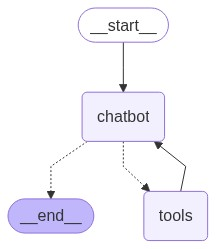

In [2]:
graphs = build_graph()
display(Image(graphs.get_graph().draw_mermaid_png()))

In [3]:
get_menu()

'{"Cheese Burger":6.0,"Chicken Burger":6.99,"Veggie Burger":5.49,"Pepperoni Pizza":12.99,"Margherita Pizza":11.49,"BBQ Chicken Pizza":13.99,"Grilled Chicken Sandwich":7.99,"Club Sandwich":6.99,"Spaghetti Carbonara":9.99,"Fettuccine Alfredo":10.49,"Tandoori Chicken":11.99,"Butter Chicken":12.49,"Beef Steak":15.99,"Chicken Biryani":8.99,"Mutton Biryani":10.99,"Prawn Curry":13.49,"Fish and Chips":9.49,"French Fries":3.99,"Garlic Bread":4.49,"Chocolate Brownie":5.49,"Vanilla Ice Cream":3.99,"Strawberry Shake":4.99,"Mango Smoothie":5.49,"Coca-Cola":2.49,"Pepsi":2.49,"Fresh Orange Juice":4.99,"Zinger burger":2.99}'

In [4]:
check_order_status('353')

'Status: Pending, Delivery: 01:41 PM'

In [5]:
cancel_order('345')

'Cannot cancel: past 10-min window.'

In [6]:
config1 = { 'configurable': { 'thread_id': '1'} }
user_input = "what's my order id?"
state = graphs.invoke(
        {"messages": [{"role": "user", "content": user_input}]},
        config=config1
    )
print(state["messages"][-1].content)

Your order ID is353.


In [30]:
# config1 = { 'configurable': { 'thread_id': '1'} }
# user_input = "my order id is 345, get item i have ordered"
# state = graphs.invoke(
#         {"messages": [{"role": "user", "content": user_input}]},
#         config=config1
#     )
# print(state["messages"][-1].content)

In [27]:
# config1 = { 'configurable': { 'thread_id': '1'} }
# user_input = "hey i want to modify my order by id is 345 and i want only 10 chicken biryani"
# state = graphs.invoke(
#         {"messages": [{"role": "user", "content": user_input}]},
#         config=config1
#     )
# print(state["messages"][-1].content)

In [8]:
# # ✅ CLI Chat Loop
# config1 = { 'configurable': { 'thread_id': '1'} }
# print("🍽️ Welcome to DineMate! Type 'exit' to quit.\n")

# while True:
#     user_input = input("👤 You: ")
#     if user_input.lower() in ['exit', 'quit']:
#         print("👋 Goodbye! Hope you enjoy your meal!")
#         break

#     state = graphs.invoke(
#         {"messages": [{"role": "user", "content": user_input}]},
#         config=config1
#     )

#     reply = state["messages"][-1].content
#     print(f"🤖 DineMate: {reply}")